# Libraries

## Install

## Import

In [1]:
# import urllib library

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen
from tqdm.notebook import tqdm as tqdm
from isoweek import Week
import seaborn as sns
import wbgapi as wb
import country_converter as coco
import time
from datetime import date
from datetime import datetime
import plotly.graph_objs as go
import os
import statistics
import researchpy as rp
from IPython.display import clear_output

import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px


In [2]:
import warnings

# Suppressing the warnings
warnings.filterwarnings('ignore') 

#Changing dir
folder = 'DATA'
try:
    os.chdir(f'{os.getcwd()}/{folder}')
except:
    dir = os.getcwd().replace(os.getcwd().split('/')[-1], folder)
    os.chdir(dir)
    
print(f'New directory: {dir}')

New directory: /Users/gustavo/Library/CloudStorage/OneDrive-Pessoal/Msc Data Analitics/Git_CA2/DATA


# Project

## Timeline

Creating timeline as requested in the assessment. Tuturial available in [Splunktool](https://splunktool.com/timeline-in-python)

In [3]:
#Creating the dates and labels
'''
28/11/22 - Assessment available
30/11/22 - Researching the subject
04/12/22 - Theme definition
05/12/22 - Research on the Theme
06/12/22 - Definition of approach and KIPs
08/12/22 - Searching Database available
10/12/22 - EDA
25/12/22 - Creating KPIs and visualizations
28/12/22 - ML (Sentimental analysis)
01/01/23 - Writing report
06/01/23 - Assessment submission
'''

dates = [date(2022, 11, 28), date(2022, 11, 30), date(2022, 12, 4), date(2022, 12, 5),
         date(2022, 12, 10), date(2022, 12, 25),
         date(2022, 12, 28), date(2023, 1, 1), date(2023, 1, 6)]
min_date = date(np.min(dates).year, np.min(dates).month, np.min(dates).day - 2)
max_date = date(np.max(dates).year, np.max(dates).month, np.max(dates).day + 2)
 
labels = ['Assessment\navailable', 'Researching the\nsubject', 'Theme\ndefinition', 
          'Research on\nthe Theme', 'Searching Database\navailable and EDA',
          'Creating KPIs and\nvisualizations', 'ML\n(Sentimental analysis)', 'Writing\nreport', 'Assessment\nsubmission']
# labels with associated dates
labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip (labels, dates)]

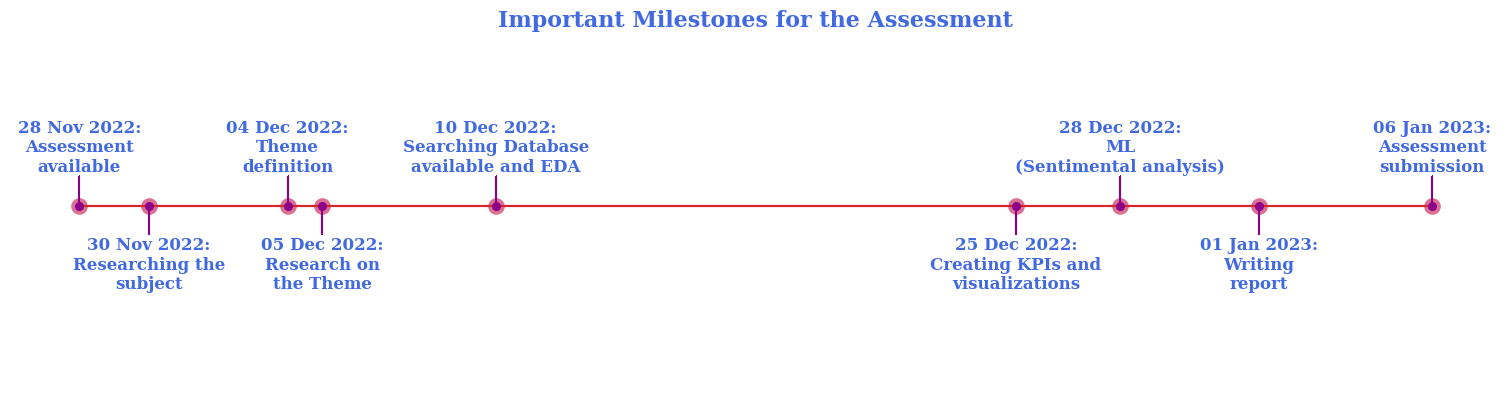

In [4]:
#Plotting

%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 4), constrained_layout=True)
_ = ax.set_ylim(-2, 1.75)
_ = ax.set_xlim(min_date, max_date)
_ = ax.axhline(0, xmin=0.05, xmax=0.95, c='deeppink', zorder=1)
 
_ = ax.scatter(dates, np.zeros(len(dates)), s=120, c='palevioletred', zorder=2)
_ = ax.scatter(dates, np.zeros(len(dates)), s=30, c='darkmagenta', zorder=3)

label_offsets = np.zeros(len(dates))
label_offsets[::2] = 0.35
label_offsets[1::2] = -0.85
for i, (l, d) in enumerate(zip(labels, dates)):
    _ = ax.text(d, label_offsets[i], l, ha='center', fontfamily='serif', fontweight='bold', color='royalblue',fontsize=12)

stems = np.zeros(len(dates))
stems[::2] = 0.3
stems[1::2] = -0.3   
markerline, stemline, baseline = ax.stem(dates, stems, use_line_collection=True)
_ = plt.setp(markerline, marker=',', color='darkmagenta')
_ = plt.setp(stemline, color='darkmagenta')


# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    _ = ax.spines[spine].set_visible(False)
     # hide tick labels
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
 
    _ = ax.set_title('Important Milestones for the Assessment', fontweight="bold", fontfamily='serif', fontsize=16, 
                 color='royalblue')

The timeline above is demonstring the schedule for this project.

# Data

Agri-Food

Looking into European Commission Portal, there is the [Agri-food Portal](https://agridata.ec.europa.eu/extensions/DataPortal/agricultural_markets.html). These site allowed us to get data from [Web API](https://agridata.ec.europa.eu/extensions/DataPortal/API_Documentation.html)

## TAXUD imports and exports

Weekly import statistics of agricultural products based on the "Surveillance" System of the Taxation and Customs Union DG, as shown in the imports and exports reports presented on the portal.

**API Parameters**

**memberStateCodes** 
    The optional codes of the EU Member States.

**products** 
    The optional product(s) must be comma-separated. For more details check REST API : `/api/taxud/weeklyData/import/products`

**importCategories** 
    The optional import categor(ies) must be comma-separated. For more details check REST API : `/api/taxud/weeklyData/importCategories`

**marketingYears** 
    The optional marketing year(s) must have the format yyyy or yyyy/yyyy.

**months** 
    The optional month(s) to search for data.

**marketingWeeks** 
    The optional week(s) of a year to search for weekly data. The first week of January is number 1.

**sectors** 
    The optional sectors to search for data. For more details check REST API : `/api/taxud/weeklyData/sectors`

**cn8ProductCodes** 
    The optional CN 8 length product code(s). For more details check REST API : `/api/taxud/weeklyData/import/cn8ProductCodes`

**taric10ProductCodes** 
    The optional CN 10 length product code(s). For more details check REST API : `/api/taxud/weeklyData/import/taric10ProductCodes`

**partnerCodes** 
    The optional partner country code(s).

In [5]:
#Functions

#Getting informations about Irish Exports for each sector available on Agrifood Portal and saving it into an DataFrame.
def taxud_sector(state, flow):
    
    state = state.lower() #state = "IE" #StateCode
    flow = flow.lower() #flow = export or import
    file_name = f'taxud_{flow[:3]}_{state}.zip'
    
    if os.path.exists(file_name) == False: #First checking if database exists
        print(f'Getting Sectors...')
        sec_df = pd.read_json("https://ec.europa.eu/agrifood/api/taxud/weeklyData/sectors") #Getting sectors
        print(f'Importing Data...')
        for i in tqdm(list(sec_df.index)): #Getting Data
            a = sec_df[0][i]
            a = a.replace(' ', '+')
            url_taxud = f'https://ec.europa.eu/agrifood/api/taxud/weeklyData/{flow}?memberStateCodes={state}&sectors={a}'
            try:
                if i == 0:
                    taxud = pd.read_json(url_taxud)
                    print(f'Read {a} {len(taxud):,} lines')
                else: 
                    df = pd.read_json(url_taxud)
                    taxud = pd.concat([taxud, df])
                    print(f'Appended {len(df):,} lines of {a}')
                #time.sleep(10)
            except:
                print(f'{a} Skipped')
            pass
        taxud.to_csv(file_name, index=False,compression='zip') #Saving Data
        
    else:
        create_dt = time.strftime("%d/%m/%Y %H:%M:%S",time.strptime(time.ctime(os.path.getmtime(file_name))))
        print(f'Reading {file_name}, created at {create_dt}')
        taxud = pd.read_csv(file_name) #if exists it'll just read the data
    
    taxud['Flow'] = flow.capitalize() #creating new feature called flow, this way is possible to identify
    print(f'DataFrame with {len(taxud):,} observations and {len(taxud.columns)} features.')
    return taxud


#Fuction to unify dataframes
def unified(file_name, df1, df2):
    file_name = f'{file_name}.zip'
    if os.path.exists(file_name) == False:
        df = pd.concat([df1, df2])
        df = df.reset_index(drop = True)
        df.to_csv(file_name, index=False,compression='zip') #saving trade DataFrame
        print(f'File {file_name} created.')
    else:
        create_dt = time.strftime("%d/%m/%Y %H:%M:%S",time.strptime(time.ctime(os.path.getmtime(file_name))))
        print(f'Reading {file_name}, created at {create_dt}')
        df = pd.read_csv(file_name)
    
    print(f'DataFrame with {len(df):,} observations and {len(df.columns)} features.')
    return df
        

### Exports

In [6]:
taxud_exp_ie = taxud_sector('IE', 'export')
taxud_exp_ie.sample(2)

Reading taxud_exp_ie.zip, created at 24/12/2022 13:35:27
DataFrame with 98,735 observations and 18 features.


sector marketingYear  marketingWeek memberStateCode memberStateName  \
89446   Beef          2022              2              IE         Ireland   
33342   Milk          2021             38              IE         Ireland   

      partnerCode                   partner product  cn8ProductCode  \
89446          US  United States of America  Offals         2062999   
33342          GB            United Kingdom  Cheese         4064090   

       taric10ProductCode  procedure  preference  euroValue  unitValue     kg  \
89446           206299900         10           0     321936       4.44  72492   
33342           406409000         10           0      10936      10.59   1033   

       kgEquivalent  coefficient    Flow  
89446         72492          1.0  Export  
33342          1033          1.0  Export

In [7]:
taxud_exp_pt = taxud_sector('PT', 'export')
taxud_exp_pt.sample(2)

Reading taxud_exp_pt.zip, created at 24/12/2022 13:35:27
DataFrame with 376,166 observations and 18 features.


sector marketingYear  marketingWeek memberStateCode memberStateName  \
183665     Pigs          2015             34              PT        Portugal   
19229   Cereals     2013/2014             32              PT        Portugal   

       partnerCode      partner                 product  cn8ProductCode  \
183665          AO       Angola  Preparations, sausages        16024210   
19229           CH  Switzerland            Common wheat        11010015   

        taric10ProductCode  procedure  preference  euroValue  unitValue   kg  \
183665          1602421000         10           0        767       8.14   94   
19229           1101001500         10           0        218       0.91  240   

        kgEquivalent  coefficient    Flow  
183665           113         1.20  Export  
19229            329         1.37  Export

### Imports

In [8]:
taxud_imp_ie = taxud_sector('IE', 'import')
taxud_imp_ie.sample(2)

Reading taxud_imp_ie.zip, created at 24/12/2022 13:35:27
DataFrame with 143,780 observations and 18 features.


sector marketingYear  marketingWeek memberStateCode memberStateName  \
138103   Rice     2020/2021             23              IE         Ireland   
10556    Pigs          2021             45              IE         Ireland   

       partnerCode         partner  \
138103          VN         Vietnam   
10556           GB  United Kingdom   

                                           product  cn8ProductCode  \
138103  Milled & semi-milled Japonica (milled eq.)        10063021   
10556                                  Frozen Meat         2032955   

        taric10ProductCode  procedure  preference  euroValue  unitValue  \
138103          1006302110         40         100         62       2.30   
10556            203295599       4000         300      57835       2.84   

           kg  kgEquivalent  coefficient    Flow  
138103     27            25         0.94  Import  
10556   20364         26473         1.30  Import

In [9]:
taxud_imp_pt = taxud_sector('PT', 'import')
taxud_imp_pt.sample(2)

Reading taxud_imp_pt.zip, created at 24/12/2022 13:35:27
DataFrame with 44,803 observations and 18 features.


sector marketingYear  marketingWeek memberStateCode memberStateName  \
43681      Wine     2013/2014             19              PT        Portugal   
12184  Oilseeds     2020/2021             41              PT        Portugal   

      partnerCode      partner              product  cn8ProductCode  \
43681          NZ  New Zealand  Still wines bottled        22042196   
12184          BR       Brazil             Soyameal        23040000   

       taric10ProductCode  procedure  preference  euroValue  unitValue     kg  \
43681          2204219621          7         100      13151       9.74   1350   
12184          2304000000         40         100      17925       0.72  25000   

       kgEquivalent  coefficient    Flow  
43681          1350          1.0  Import  
12184         25000          1.0  Import

### Unifying

Saving dataframe so we don't need to execute de API conection again and the data won't change (update). 

In [10]:
#unifying Dataframe
trade_ie = unified('trade_ie', taxud_imp_ie, taxud_exp_ie)
trade_pt = unified('trade_pt', taxud_imp_pt, taxud_exp_pt)

# releasing memory
del [taxud_imp_ie, taxud_exp_ie, taxud_exp_pt, taxud_imp_pt]


Reading trade_ie.zip, created at 24/12/2022 13:35:27
DataFrame with 242,515 observations and 18 features.
Reading trade_pt.zip, created at 24/12/2022 13:35:27
DataFrame with 420,969 observations and 18 features.


### Reading
Starting from here, so the data won't change and will be quickly

In [11]:
trade_ie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242515 entries, 0 to 242514
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   sector              242515 non-null  object 
 1   marketingYear       242515 non-null  object 
 2   marketingWeek       242515 non-null  int64  
 3   memberStateCode     242515 non-null  object 
 4   memberStateName     242515 non-null  object 
 5   partnerCode         242368 non-null  object 
 6   partner             242515 non-null  object 
 7   product             242515 non-null  object 
 8   cn8ProductCode      242515 non-null  int64  
 9   taric10ProductCode  242515 non-null  int64  
 10  procedure           242515 non-null  int64  
 11  preference          242515 non-null  int64  
 12  euroValue           242515 non-null  int64  
 13  unitValue           242515 non-null  float64
 14  kg                  242515 non-null  int64  
 15  kgEquivalent        242515 non-nul

In [12]:
trade_ie.tail(5)

sector marketingYear  marketingWeek memberStateCode memberStateName  \
242510  Tomato     2016/2017             15              IE         Ireland   
242511  Tomato     2020/2021             29              IE         Ireland   
242512  Tomato     2020/2021             50              IE         Ireland   
242513  Tomato     2021/2022             14              IE         Ireland   
242514  Tomato     2020/2021             45              IE         Ireland   

       partnerCode                                  partner   product  \
242510          TR                                   Turkey  TOMATOES   
242511          SG                                Singapore  TOMATOES   
242512          QU  Countries and territories not specified  TOMATOES   
242513          QU  Countries and territories not specified  TOMATOES   
242514          QU  Countries and territories not specified  TOMATOES   

        cn8ProductCode  taric10ProductCode  procedure  preference  euroValue  \
242510         7020000           702000000         10           0      10000   
242511         7020000           702000000         10           0         88   
242512         7020000           702000000         31           0          1   
242513         7020000           702000000         31           0        679   
242514         7020000           702000000         31           0         74   

        unitValue    kg  kgEquivalent  coefficient    Flow  
242510       2.19  4568          4568          1.0  Export  
242511       4.19    21            21          1.0  Export  
242512       0.50     2             2          1.0  Export  
242513      16.97    40            40          1.0  Export  
242514      18.53     4             4          1.0  Export

In [13]:
trade_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420969 entries, 0 to 420968
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   sector              420969 non-null  object 
 1   marketingYear       420969 non-null  object 
 2   marketingWeek       420969 non-null  int64  
 3   memberStateCode     420969 non-null  object 
 4   memberStateName     420969 non-null  object 
 5   partnerCode         419870 non-null  object 
 6   partner             420969 non-null  object 
 7   product             420969 non-null  object 
 8   cn8ProductCode      420969 non-null  int64  
 9   taric10ProductCode  420969 non-null  int64  
 10  procedure           420969 non-null  int64  
 11  preference          420969 non-null  int64  
 12  euroValue           420969 non-null  int64  
 13  unitValue           420969 non-null  float64
 14  kg                  420969 non-null  int64  
 15  kgEquivalent        420969 non-nul

In [14]:
trade_pt.tail(5)

sector marketingYear  marketingWeek memberStateCode memberStateName  \
420964   Wine     2016/2017             27              PT        Portugal   
420965   Wine     2016/2017             27              PT        Portugal   
420966   Wine     2016/2017             27              PT        Portugal   
420967   Wine     2016/2017             27              PT        Portugal   
420968   Wine     2016/2017             27              PT        Portugal   

       partnerCode        partner              product  cn8ProductCode  \
420964          CH    Switzerland  Still wines bottled        22042178   
420965          GW  Guinea-Bissau  Still wines bottled        22042184   
420966          NO         Norway          Other Wines        22041098   
420967          MO          Macao  Still wines bottled        22042184   
420968          AO         Angola            PGI Wines        22042179   

        taric10ProductCode  procedure  preference  euroValue  unitValue    kg  \
420964          2204217800         10           0       6911       2.46  2815   
420965          2204218400         10           0       9360       1.11  8448   
420966          2204109800         10           0         16       1.33    12   
420967          2204218400         10           0       1955       1.23  1590   
420968          2204217900         10           0       1176       1.97   598   

        kgEquivalent  coefficient    Flow  
420964          2815          1.0  Export  
420965          8448          1.0  Export  
420966            12          1.0  Export  
420967          1590          1.0  Export  
420968           598          1.0  Export

### Date Time

Adjusting the Time features and setting as timestamp

In [15]:
def get_date(df, year_col, week_col):
    temp_date = df[year_col].astype({'marketingYear':'str'}).str.split("/", n = 1, expand = True) #Spliting dates
    temp_date = pd.concat([temp_date, df[week_col]], axis = 1)
    temp_date = temp_date.rename(columns={0:'year', 1:'year_2', week_col:'week'})
    temp_date = temp_date.astype({'year':'int64', 'week':'int64'})
    temp_date['date'] = temp_date.apply(lambda x: Week(x['year'], x['week']).monday(), axis=1)#getting data
        
    return pd.concat([df, temp_date.loc[:,['year', 'date']]], axis = 1)
        

In [16]:
trade_ie = get_date(trade_ie, 'marketingYear', 'marketingWeek')
trade_ie.sample(3)

sector marketingYear  marketingWeek memberStateCode memberStateName  \
154485     Pigs          2021             43              IE         Ireland   
195568     Milk          2021             22              IE         Ireland   
4349    Poultry          2022             45              IE         Ireland   

       partnerCode         partner                 product  cn8ProductCode  \
154485          GB  United Kingdom  Preparations, sausages        16024919   
195568          CH     Switzerland                  Cheese         4069021   
4349            GB  United Kingdom    Poultry preparations        16023230   

        taric10ProductCode  procedure  preference  euroValue  unitValue  \
154485          1602491900         10           0    1511302      11.36   
195568           406902100         10           0        225      13.22   
4349            1602323090       4000         100        664       4.49   

            kg  kgEquivalent  coefficient    Flow  year        date  
154485  133079        159695         1.20  Export  2021  2021-10-25  
195568      17            17         1.00  Export  2021  2021-05-31  
4349       148            66         0.45  Import  2022  2022-11-07

In [17]:
trade_pt = get_date(trade_pt, 'marketingYear', 'marketingWeek')
trade_pt.sample(3)

sector marketingYear  marketingWeek  \
266002                     Spirits          2019             51   
19906   Other fruit and vegetables          2016              8   
72433                 Citrus fruit     2014/2015             14   

       memberStateCode memberStateName partnerCode                   partner  \
266002              PT        Portugal          US  United States of America   
19906               PT        Portugal          CR                Costa Rica   
72433               PT        Portugal          AO                    Angola   

                    product  cn8ProductCode  taric10ProductCode  procedure  \
266002  Other Spirit Drinks        22089069          2208906900         10   
19906       (fresh) Bananas         8039010           803901000         40   
72433                Lemons         8055010           805501000         10   

        preference  euroValue  unitValue     kg  kgEquivalent  coefficient  \
266002           0      14063       3.88   3624          3624          1.0   
19906          100      14766       0.58  25356         25356          1.0   
72433            0       3895       0.38  10297         10297          1.0   

          Flow  year        date  
266002  Export  2019  2019-12-16  
19906   Import  2016  2016-02-22  
72433   Export  2014  2014-03-31

## CMEF Indicator data
The Common Monitoring and Evaluation Framework (CMEF) for the CAP 2014-2020 identifies a set of performance indicators in four categories: context, output, result and impact. Context indicators provide information on agricultural and rural statistics as well as general economic and environmental trends.

[API Documentation](https://agridata.ec.europa.eu/extensions/DataPortal/API_Documentation.html)

In [18]:
#Funcitons

def get_indicators(state, years, file_name):
    url_cmef = 'https://ec.europa.eu/agrifood/api/cmefIndicators/'
    file_name = f'{file_name}.bz2'
   

    if os.path.exists(file_name) == False: #First checking if database exists
        print(f'Getting Data...')    
    
        for s in state:
            s = s.upper() #state = "IE" #StateCode   
            try:
                if s == state[0]:
                    ind = pd.read_json(f'https://ec.europa.eu/agrifood/api/cmefIndicators/values?memberStateCodes={s}&years={years}')
                    print(f'Read {len(ind):,} lines of {s}')
                else: 
                    df = pd.read_json(f'https://ec.europa.eu/agrifood/api/cmefIndicators/values?memberStateCodes={s}&years={years}')
                    ind = pd.concat([ind, df])
                    print(f'Appended {len(df):,} lines of {s}')

            except:
                print(f'We got an Error getting data from {s} in {years}')
            pass

        print('Data received, saving...')
        ind.to_csv(file_name, index=False,compression='bz2') #Saving Data
        print(f'File saved as {file_name}')    
    
    else:
        create_dt = time.strftime("%d/%m/%Y %H:%M:%S",time.strptime(time.ctime(os.path.getmtime(file_name))))
        print(f'Reading {file_name}, created at {create_dt}')
        ind = pd.read_csv(file_name) #if exists it'll just read the data        
    
    print(f'DataFrame with {len(ind):,} observations and {len(ind.columns)} features available')
    
    return ind
                      

In [19]:
cc = coco.CountryConverter()

UE19 = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Denmark', 'Finland', 'France', 'Germany', 'Hungary',
        'Ireland', 'Italy', 'Latvia', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain','Sweden']

#GETTING COUNTRIES CODE
UE19_ISO2 = cc.convert(names =UE19, to='ISO2')

In [20]:
ind = get_indicators(UE19_ISO2, '2020,2019,2018,2017,2016,2015', 'cmef')
ind.sample(2)

Reading cmef.bz2, created at 28/12/2022 19:40:17
DataFrame with 89,781 observations and 11 features available


indicator                           subindicator  \
1870  OIR_01 Total public expenditure  total EU expenditure under measure 15   
630   C.25 Agricultural factor income         Agricultural output per sector   

             parameter                            unit              code  \
1870          EU funds                            euro      OIR_01b_2.15   
630   industrial crops  EUR - values at current prices  CTX_SEC_25_5_b_5   

                                                 source memberStateCode  \
1870                                                DOE              AT   
630   Eurostat, Economic Accounts for Agriculture (a...              AT   

     memberStateName  year     value flag  
1870         Austria  2018  87358.63  NaN  
630          Austria  2019    275.16  NaN

In [21]:
print(f'Number of indicators: {len(ind.code.unique())}')

Number of indicators: 1212


In [22]:
ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89781 entries, 0 to 89780
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   indicator        89781 non-null  object 
 1   subindicator     87895 non-null  object 
 2   parameter        87895 non-null  object 
 3   unit             89697 non-null  object 
 4   code             89781 non-null  object 
 5   source           75746 non-null  object 
 6   memberStateCode  89781 non-null  object 
 7   memberStateName  89781 non-null  object 
 8   year             89781 non-null  int64  
 9   value            89781 non-null  float64
 10  flag             1583 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 7.5+ MB


# Social Indicators

## Population living in Rural Regions

Undertanding how large is the population living in Rural Regions, so we can understand how important de rural regions is for the country.

### Distribution

In [23]:
ind_rural = ind[ind.code == 'CTX_SOC_01_2a']
ind_rural.sample(2)

indicator                                  subindicator  \
2093  C.01 Population  Distribution of population by type of region   
7579  C.01 Population  Distribution of population by type of region   

          parameter        unit           code    source memberStateCode  \
2093  rural regions  % of total  CTX_SOC_01_2a  EUROSTAT              AT   
7579  rural regions  % of total  CTX_SOC_01_2a  EUROSTAT              BE   

     memberStateName  year  value flag  
2093         Austria  2017  40.49  NaN  
7579         Belgium  2016   8.54  NaN

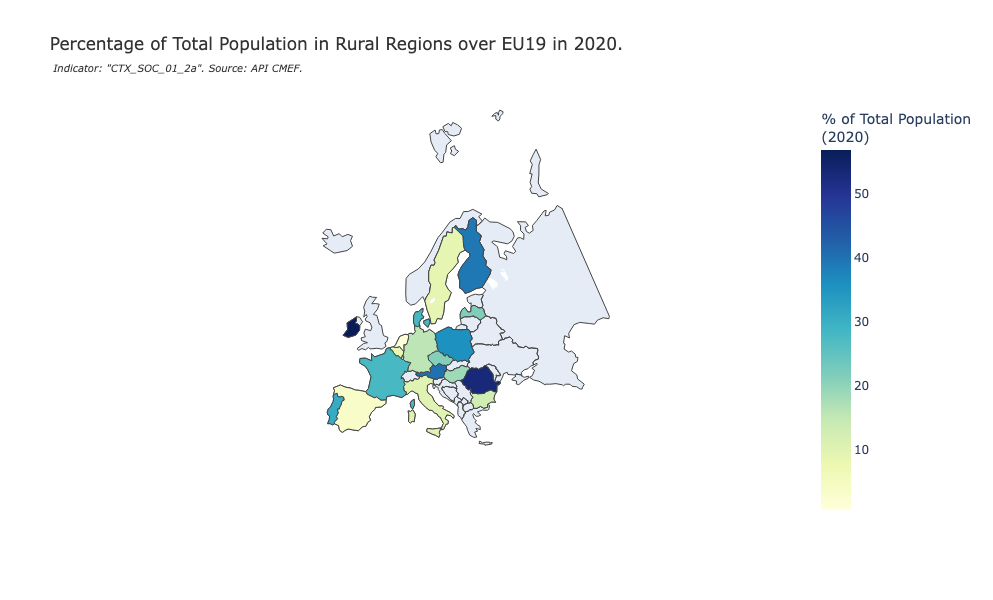

In [24]:
#Distribution of population in Rural Regions (% of Total)

year = 2020

title = f'Percentage of Total Population in Rural Regions over EU19 in {year}.' \
        f'<br><span style="font-size:10px"><i> Indicator: "CTX_SOC_01_2a". Source: API CMEF.</span></i>'


choropleth_map = go.Figure(
    data = {
        'type':'choropleth',
        'locations':ind_rural[ind_rural.year == year]['memberStateName'],
        'locationmode':'country names',
        'colorscale':'YlGnBu',            
        'text':ind_rural[ind_rural.year == year]['memberStateName'],
        'z':ind_rural[ind_rural.year == year]['value'],
        'colorbar':{'title':f'% of Total Population<br>({year})'},
        },
 
    layout = {
        'width':800,
        'height':600,
          'geo':{
              'scope':'europe'
          }  
    })

choropleth_map.update_layout(
    showlegend=True,
    title_text= title,
    title_font_color='#333333',
    legend_font_color='gray',
    legend_itemclick='toggleothers',
    legend_itemdoubleclick='toggle',
    plot_bgcolor='white'
)

choropleth_map

Although plotting the graph of Europe is visually beautiful, it is not possible to reach a numerical conclusion of the difference between the EU-19 countries.

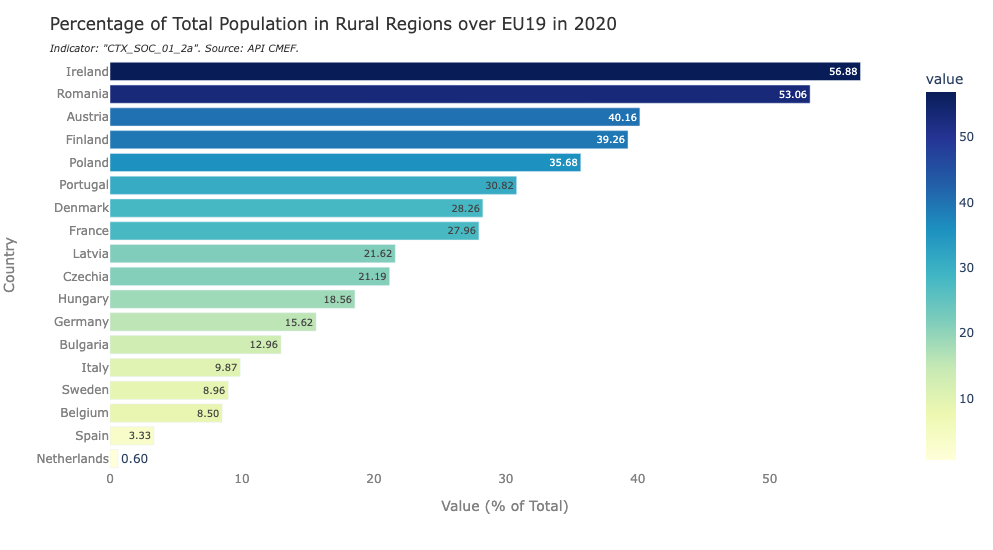

In [25]:
year = 2020

source = ind_rural[ind_rural.year == year]

title = f'Percentage of Total Population in Rural Regions over EU19 in {year}' \
        f'<br><span style="font-size:10px"><i>Indicator: "CTX_SOC_01_2a". Source: API CMEF.</span></i>'

fig = px.bar(
    source,
    y = 'memberStateName',
    x = 'value',
    color = 'value',
    text = source['value'].map('{:,.2f}'.format),
    orientation = "h",
    barmode='group',
    color_continuous_scale='YlGnBu'
    )


fig.update_layout(
    showlegend=False,
    title_text=title,
    title_font_color='#333333',
    legend_font_color='gray',
    legend_itemclick='toggleothers',
    legend_itemdoubleclick='toggle',
    width = 800,
    height=550,
    plot_bgcolor='white',
    xaxis_title_font_color='grey',
    xaxis_color='grey',
    yaxis_title_font_color='grey',
    yaxis_color='grey',
    
    xaxis_title_text = 'Value (% of Total)',
    yaxis_title_text = 'Country',
        )

fig.update_yaxes(categoryorder='total ascending')


fig.show()

The plot above shows the rank of countries (UE19) with the highest percentage of the population living in rural regions, using the same colour scheme. Thus, it is possible to see that Ireland is the country with the highest percentage of its population living in rural areas, and along with Romania they are the two countries that have most of their population (more than 50%) living in rural regions.

### Mean

Analyzing the mean per year of the population living in rural areas of the EU-19 countries

In [26]:
def get_mean(df, mean_by, column_value, column_desc, desc):
    df = df.copy()
    print(f"Getting {desc} by {mean_by}")
    filters = df[f'{mean_by}'].unique()
    for f in range(len(filters)):
        x = len(df) + f + 1
        df.loc[x,f'{column_desc}'] =  desc
        df.loc[x,f'{mean_by}'] = filters[f]
        m = df[(df[f'{mean_by}'] == filters[f])][f'{column_value}'].mean()
        df.loc[x,f'{column_value}'] = m
        print(f"{filters[f]}: {m:.6f}")
    print(f"Mean Total: {df[f'{column_value}'].mean():.6f}\n\n")
    return df

In [27]:
def get_summary_cont(df, stats_by, column_value):
    filters = df[f'{stats_by}'].unique()
    dataframe = pd.DataFrame()
    
    for f in range(len(filters)):
  
        if f == filters[0]:
            dataframe = rp.summary_cont(df[df[f'{stats_by}'] == filters[f]][f'{column_value}'])
            dataframe.loc[f,f'{stats_by}'] = filters[f]
        else:
            data = rp.summary_cont(df[df[f'{stats_by}'] == filters[f]][f'{column_value}'])
            data.loc[0,f'{stats_by}'] = filters[f]
            dataframe = pd.concat([dataframe,data])
    
    dataframe = dataframe.reset_index(drop=True)
    clear_output()
    return dataframe

### Difference between years

The Dataframe below was created to check the difference in population living in rural areas between 2015 and 2020 of EU-19 countries

In [28]:
#Creating a df of the differencies between the previous year.

def get_diff(df, index, columns, values, sort_index_ascending):
    df = pd.pivot(df, index, columns, values).sort_index(ascending = sort_index_ascending)
    for c in df.columns:
        df[f'{c}'] = df[f'{c}'].diff()
    col = df.columns
    df = df.reset_index()
    df =pd.melt(df, id_vars=index, value_vars=col)
    df = df.fillna(0)
    
    return df

In [29]:
ind_rural_m = ind_rural.loc[:,['memberStateName', 'year', 'value']].reset_index(drop = True)
ind_rural_m = get_mean(df = ind_rural_m, 
                         mean_by = 'year', 
                         column_value = 'value', 
                         column_desc = 'memberStateName',
                         desc = 'Mean EU-19')

Getting Mean EU-19 by year
2020: 24.071667
2019: 24.143333
2018: 24.226111
2017: 24.308333
2016: 24.385556
2015: 24.470556
Mean Total: 24.267593




In [30]:
#Creating a DataFrame with difference between 2015 and 2020

ind_rural_m_d2 = get_diff(ind_rural_m[ind_rural_m['year'].isin([2015, 2020])],
                          index = 'year', 
                          columns ='memberStateName', 
                          values='value',
                          sort_index_ascending = True)
ind_rural_m_d2 = ind_rural_m_d2[ind_rural_m_d2['year'] == 2020]
ind_rural_m_d2


year memberStateName     value
1   2020.0         Austria -0.740000
3   2020.0         Belgium -0.020000
5   2020.0        Bulgaria -0.200000
7   2020.0         Czechia -0.050000
9   2020.0         Denmark -0.490000
11  2020.0         Finland -1.010000
13  2020.0          France -0.370000
15  2020.0         Germany -0.210000
17  2020.0         Hungary -0.460000
19  2020.0         Ireland -0.670000
21  2020.0           Italy -0.090000
23  2020.0          Latvia -0.590000
25  2020.0      Mean EU-19 -0.398889
27  2020.0     Netherlands -0.030000
29  2020.0          Poland -0.360000
31  2020.0        Portugal -0.700000
33  2020.0         Romania -0.850000
35  2020.0           Spain -0.190000
37  2020.0          Sweden -0.150000

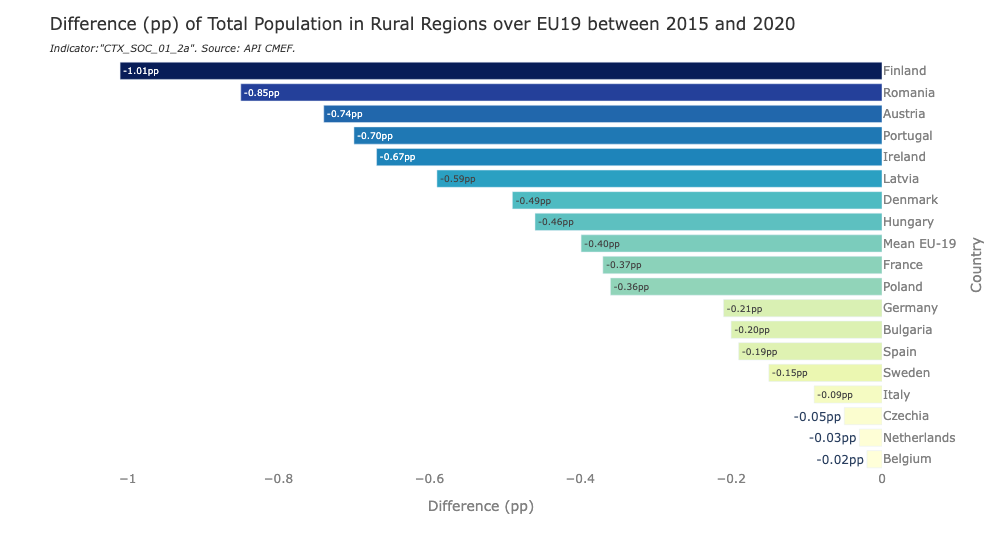

In [31]:
source = ind_rural_m_d2

title = 'Difference (pp) of Total Population in Rural Regions over EU19 between 2015 and 2020' \
        f'<br><span style="font-size:10px"><i>Indicator:"CTX_SOC_01_2a". Source: API CMEF.</span></i>'

fig = px.bar(
    source,
    y = 'memberStateName',
    x = 'value',
    color = 'value',
    text = source['value'].map('{:,.2f}pp'.format),
    orientation = "h",
    barmode='group',
    color_continuous_scale='YlGnBu_r'
    )


fig.update_layout(
    showlegend=False,
    title_text=title,
    title_font_color='#333333',
    legend_font_color='gray',
    legend_itemclick='toggleothers',
    legend_itemdoubleclick='toggle',
    width = 800,
    height=550,
    plot_bgcolor='white',
    xaxis_title_font_color='grey',
    xaxis_color='grey',
    yaxis_title_font_color='grey',
    yaxis_color='grey',
    coloraxis_showscale=False,
    xaxis_title_text = 'Difference (pp)',
    yaxis_title_text = 'Country',
        )

fig.update_yaxes(categoryorder='total descending',
                side="right")


fig.show()

### Working with numbers absolute

#### Data Frames

##### Rural

In [32]:
ind_rural_n = ind[ind.code == 'CTX_SOC_01_1b'].loc[:,['memberStateName', 'year', 'value']].reset_index(drop = True)
                

ind_rural_n2 = get_diff(df = ind_rural_n, 
                         index = 'year', 
                         columns ='memberStateName', 
                         values='value', 
                         sort_index_ascending = True)

ind_rural_n = ind_rural_n.merge(ind_rural_n2, how='inner', on=['memberStateName','year'])
del ind_rural_n2
ind_rural_n.sample()

memberStateName  year    value_x  value_y
32         Finland  2018  2188424.0  -8050.0

##### General

In [33]:
ind_total_n = ind[ind.code == 'CTX_SOC_01_1a'].loc[:,['memberStateName', 'year', 'value']].reset_index(drop = True)
                

ind_total_n2 = get_diff(df = ind_total_n, 
                         index = 'year', 
                         columns ='memberStateName', 
                         values='value', 
                         sort_index_ascending = True)

ind_total_n = ind_total_n.merge(ind_total_n2, how='inner', on=['memberStateName','year'])
del ind_total_n2
ind_total_n.sample()

memberStateName  year     value_x  value_y
89          Poland  2015  38005614.0      0.0

#### By Year

In [34]:
##GETTING RURAL STATISTICS DATA BY YEAR
stats_rural_dif_y = get_summary_cont(ind_rural_n, 'year', 'value_y')
stats_rural_dif_y['Variable'] = 'Rural Population'

##GETTING GENERAL STATISTICS DATA BY COUNTRY
stats_total_dif_y = get_summary_cont(ind_total_n, 'year', 'value_y')
stats_total_dif_y['Variable'] = 'General Population'

#UNIFYING
stats_dif_y = pd.concat([stats_total_dif_y, stats_rural_dif_y]).reset_index(drop = True)
del [stats_total_dif_y, stats_rural_dif_y]

stats_dif_y.sample()

Variable     N        Mean          SD          SE  95% Conf.  \
2  General Population  19.0  39467.1579  96907.8299  22232.1809  -7240.921   

     Interval    year  
2  86175.2368  2018.0

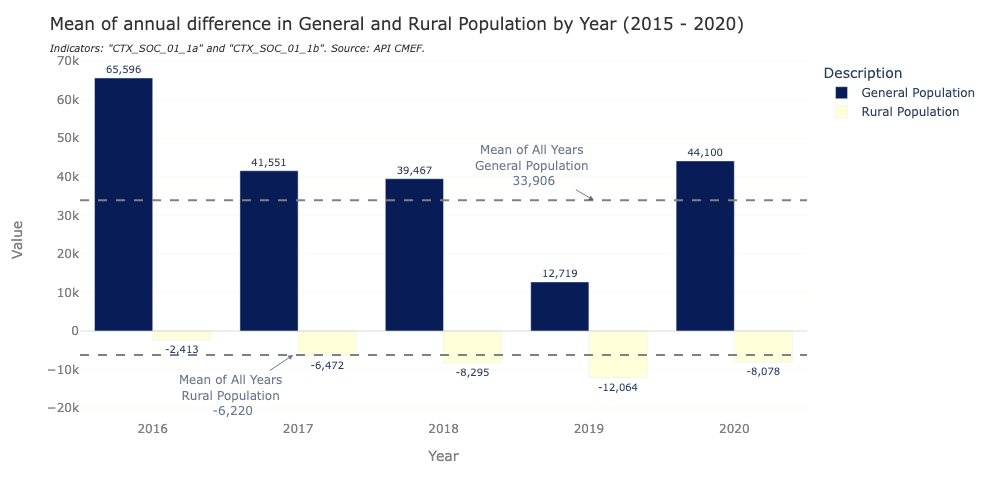

In [35]:
source = stats_dif_y[stats_dif_y.year != 2015]

title = f'Mean of annual difference in General and Rural Population by Year (2015 - 2020)' \
        f'<br><span style="font-size:10px"><i>Indicators: "CTX_SOC_01_1a" and "CTX_SOC_01_1b". Source: API CMEF.</span></i>'

mean_total = ind_total_n['value_y'].mean()
mean_rural = ind_rural_n['value_y'].mean()


fig = px.bar(
    source,
    x = 'year',
    y = 'Mean',
    color = 'Variable',
    text = source['Mean'].map('{:,.0f}'.format),
    orientation = "v",
    barmode='group',
    color_discrete_map={"General Population": "#081d58", "Rural Population" : "#ffffd9"},
    )

fig.update_layout(
    showlegend=True,
    title_text=title,
    title_font_color='#333333',
    width = 900,
    height=500,
    plot_bgcolor='white',
    #yaxis_visible=False,
    yaxis_title_font_color='gray',
    yaxis_color='gray',
    xaxis_color='gray',
    xaxis_title_text = 'Year',
    yaxis_title_text = 'Value',
    legend_title_text= 'Description',
    yaxis_gridcolor = '#F7FCF0',
    coloraxis_showscale=False)

fig.add_hline(y=0, 
              line_width=0.3, 
              #line_dash="dash", 
              line_color="gray")

fig.add_hline(y= mean_rural, 
              line_width=2, 
              line_dash="dash", 
              line_color="gray")

fig.add_hline(y= mean_total, 
              line_width=2, 
              line_dash="dash", 
              line_color="gray")


fig.add_annotation(x=2017, y=mean_rural,
                   text= f"Mean of All Years <br>Rural Population <br>{mean_rural:,.0f}",
                   showarrow=True,
                   arrowhead=2,
                   ax=-60,
                   ay=40,
                   opacity=0.7,
                   xshift=-5)

fig.add_annotation(x=2019 , y= mean_total,
                   text= f"Mean of All Years <br>General Population <br>{mean_total:,.0f}",
                   showarrow=True,
                   arrowhead=2,
                   ax=-60,
                   ay=-35,
                   opacity=0.7,
                   xshift=5)


fig.update_traces(textposition='outside', textfont_size=10)

fig.show()

as noted in the Figure 6, the mean of annual difference in the general population of the EU-19 countries has been positive, while the mean of rural population of these same countries is negative. 

#### By Country

##### Rural

In [36]:
##GETTING RURAL STATISTICS DATA BY COUNTRY
stats_rural_dif_c = get_summary_cont(ind_rural_n, 'memberStateName', 'value_y')
stats_rural_dif_c['Variable'] = 'Rural Population'

##GETTING GENERAL STATISTICS DATA BY COUNTRY
stats_total_dif_c = get_summary_cont(ind_total_n, 'memberStateName', 'value_y')
stats_total_dif_c['Variable'] = 'General Population'

#UNIFYING
stats_dif_c = pd.concat([stats_total_dif_c, stats_rural_dif_c]).reset_index(drop = True)
del [stats_total_dif_c, stats_rural_dif_c]

stats_dif_c.sample()

Variable    N         Mean          SD          SE   95% Conf.  \
7  General Population  6.0  143677.1667  74967.4203  30605.3212  65003.6839   

      Interval memberStateName  
7  222350.6494          France

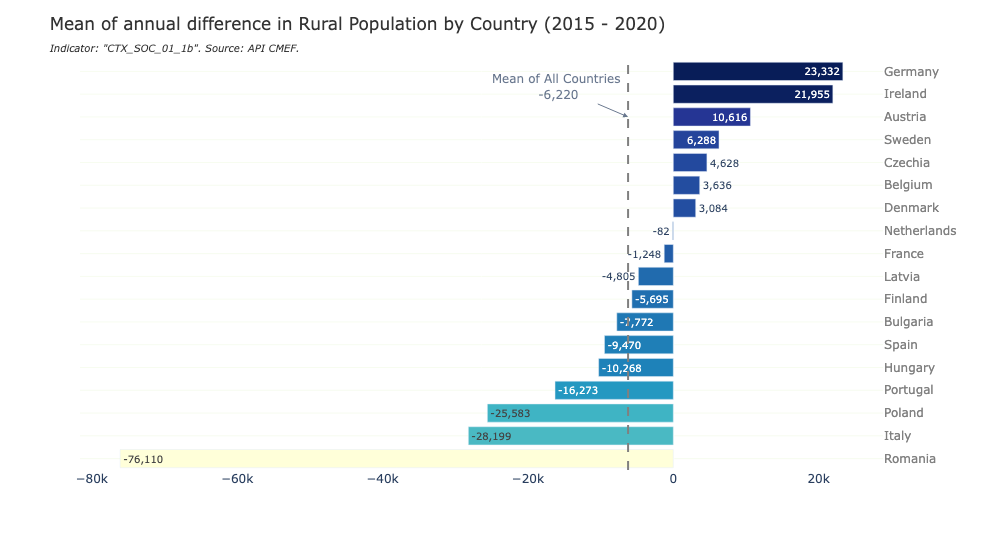

In [37]:

source = stats_dif_c[stats_dif_c['Variable'] == 'Rural Population']

title = f'Mean of annual difference in Rural Population by Country (2015 - 2020)' \
        f'<br><span style="font-size:10px"><i>Indicator: "CTX_SOC_01_1b". Source: API CMEF.</span></i>'

fig = px.bar(
    source,
    y = 'memberStateName',
    x = 'Mean',
    color = 'Mean',
    text = source['Mean'].map('{:,.0f}'.format),
    orientation = "h",
    barmode='group',
    color_continuous_scale='YlGnBu'
    )

fig.add_vline(x=ind_rural_n['value_y'].mean(), 
              line_width=2, 
              line_dash="dash", 
              line_color="gray")


fig.add_annotation(x=ind_rural_n['value_y'].mean(), y='Austria',
                   text= f"Mean of All Countries <br>{ind_rural_n['value_y'].mean():,.0f}",
                   showarrow=True,
                   arrowhead=2,
                   ax=-70,
                  opacity=0.7)


fig.update_layout(
    showlegend=False,
    title_text=title,
    title_font_color='#333333',
    width = 800,
    height=550,
    plot_bgcolor='white',
    #yaxis_visible=False,
    yaxis_title_font_color='gray',
    yaxis_color='gray',
    xaxis_title_text = '',
    yaxis_title_text = '',
    yaxis_gridcolor = '#F7FCF0',
    xaxis_showgrid=True, 
    coloraxis_showscale=False)

fig.update_traces(textfont_size=10)

fig.update_yaxes(categoryorder='total ascending', side="right")


fig.show()

The graph above shows that Romania has been losing approximately 76,110 people in rural areas per year from 2015 to 2020. We also see that Germany is the country that has been gaining the most rural population (approx. 23,331 people per year), followed by Ireland which earn approx. 21955 people per year.

##### General

Although the percentage number is decreasing compared to the total population, the Total of population has been growing by an average of 33,905 people per year. This demonstrates that in some country, as Ireland, the population is growing more in non-rural areas than in rural areas, however, in absolute numbers the number of people living in rural areas continues to grow.

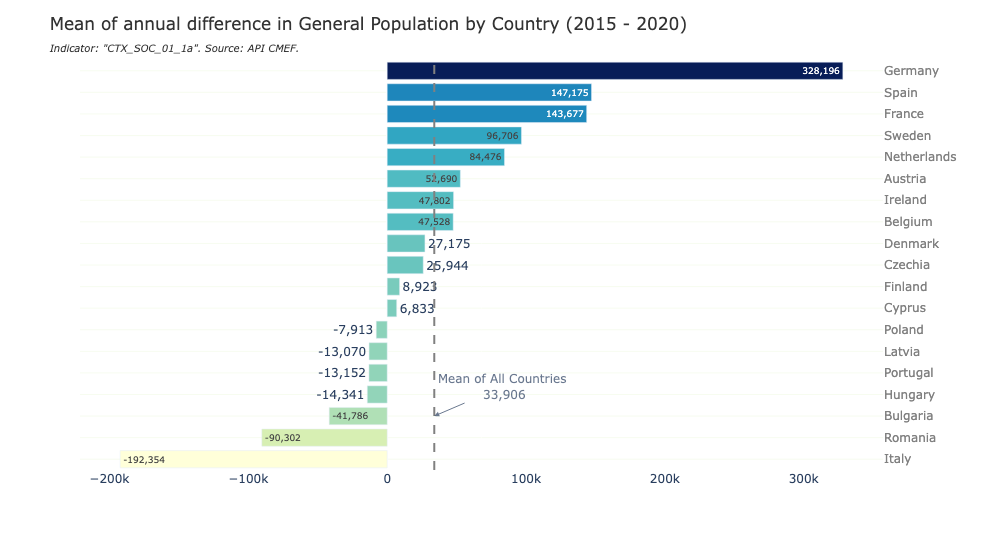

In [38]:
source = stats_dif_c[stats_dif_c['Variable'] ==  'General Population']
mean = ind_total_n['value_y'].mean()

title = f'Mean of annual difference in General Population by Country (2015 - 2020)' \
        f'<br><span style="font-size:10px"><i>Indicator: "CTX_SOC_01_1a". Source: API CMEF.</span></i>'

fig = px.bar(
    source,
    y = 'memberStateName',
    x = 'Mean',
    color = 'Mean',
    text = source['Mean'].map('{:,.0f}'.format),
    orientation = "h",
    barmode='group',
    color_continuous_scale='YlGnBu'
    )

fig.add_vline(x= mean, 
              line_width=2, 
              line_dash="dash", 
              line_color="gray")


fig.add_annotation(x= mean, y='Bulgaria',
                   text= f"Mean of All Countries <br>{mean:,.0f}",
                   showarrow=True,
                   arrowhead=2,
                   ax=70,
                   opacity=0.7)


fig.update_layout(
    showlegend=False,
    title_text=title,
    title_font_color='#333333',
    width = 800,
    height=550,
    plot_bgcolor='white',
    #yaxis_visible=False,
    yaxis_title_font_color='gray',
    yaxis_color='gray',
    xaxis_title_text = '',
    yaxis_title_text = '',
    yaxis_gridcolor = '#F7FCF0',
    xaxis_showgrid=True, 
    coloraxis_showscale=False,
    legend_font_color='gray',
    legend_itemclick='toggleothers',
    legend_itemdoubleclick='toggle')

fig.update_yaxes(categoryorder='total ascending', side="right")


fig.show()

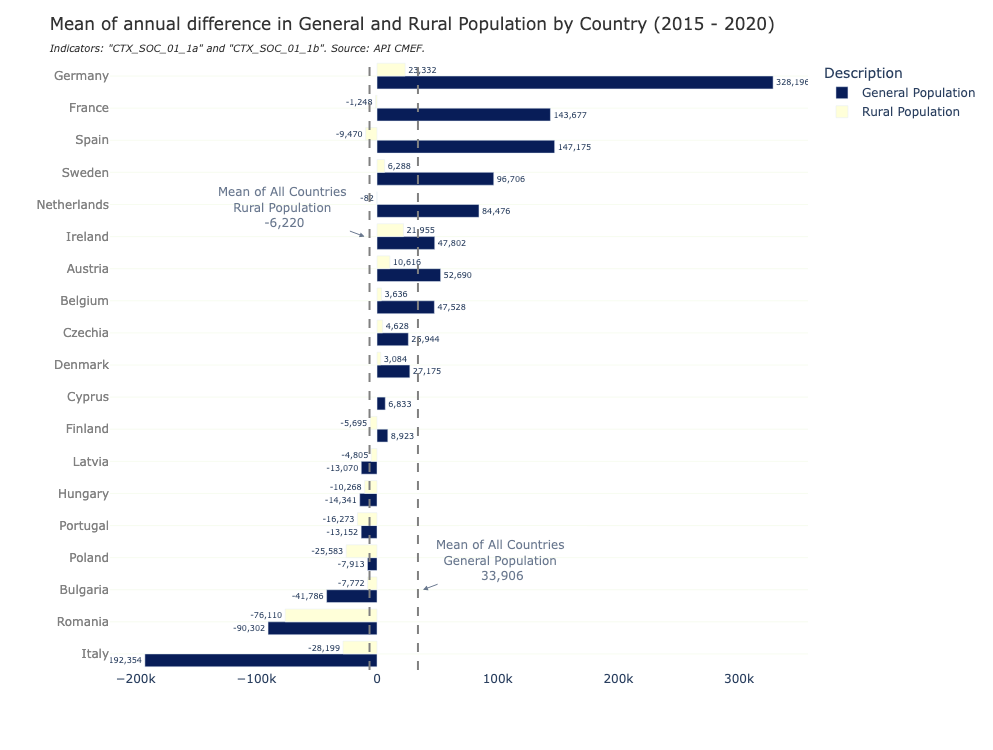

In [39]:
source = stats_dif_c
mean_total = ind_total_n['value_y'].mean()
mean_rural = ind_rural_n['value_y'].mean()

title = f'Mean of annual difference in General and Rural Population by Country (2015 - 2020)' \
        f'<br><span style="font-size:10px"><i>Indicators: "CTX_SOC_01_1a" and "CTX_SOC_01_1b". Source: API CMEF.</span></i>'

fig = px.bar(
    source,
    y = 'memberStateName',
    x = 'Mean',
    color = 'Variable',
    text = source['Mean'].map('{:,.0f}'.format),
    orientation = "h",
    barmode='group',
    color_discrete_map={"General Population": "#081d58", "Rural Population" : "#ffffd9"},
    )

fig.add_vline(x= mean_rural, 
              line_width=2, 
              line_dash="dash", 
              line_color="gray")

fig.add_vline(x= mean_total, 
              line_width=2, 
              line_dash="dash", 
              line_color="gray")


fig.add_annotation(x= mean_rural, y='Ireland',
                   text= f"Mean of All Countries <br>Rural Population <br>{mean_rural:,.0f}",
                   showarrow=True,
                   arrowhead=2,
                   ax=-80,
                   opacity=0.7,
                   xshift=-5)

fig.add_annotation(x= mean_total, y='Bulgaria',
                   text= f"Mean of All Countries <br>General Population <br>{mean_total:,.0f}",
                   showarrow=True,
                   arrowhead=2,
                   ax=80,
                   opacity=0.7,
                   xshift=5)


fig.update_layout(
    showlegend=True,
    title_text=title,
    title_font_color='#333333',
    width = 900,
    height=750,
    plot_bgcolor='white',
    #yaxis_visible=False,
    yaxis_title_font_color='gray',
    yaxis_color='gray',
    xaxis_title_text = '',
    yaxis_title_text = '',
    yaxis_gridcolor = '#F7FCF0',
    xaxis_showgrid=True, 
    coloraxis_showscale=False,
    legend_title_text= 'Description',)

fig.update_yaxes(categoryorder='total ascending', side="left")

fig.update_traces(textfont_size=8, textposition='outside')

fig.show()

In [40]:
def plot_bar_dif(source, x, y, color, trace_colors, showlegend):
    fig = px.bar(
        source,
        x = x,
        y = y,
        orientation = "v",
        text = source[y].map('{:,.0f}'.format),
        color = color,
        barmode='group',
        color_discrete_map = trace_colors
        )


    fig.update_layout(
        showlegend=showlegend,
        title_text=title,
        title_font_color='#333333',
        legend_font_color='gray',
        legend_itemclick='toggleothers',
        legend_itemdoubleclick='toggle',
        width = 900,
        height=550,
        plot_bgcolor='white',
        xaxis_title_font_color='grey',
        xaxis_color='grey',
        yaxis_title_font_color='grey',
        yaxis_color='grey',
            )

    return fig

#### Non-Rural and Rural Populations

In [41]:
ind_total_n = ind_total_n.rename(columns={"value_x": "total", "value_y": "total_diff"})
print(f'General Number of Rows: {len(ind_total_n)}')

ind_rural_n = ind_rural_n.rename(columns={"value_x": "rural", "value_y": "rural_diff"})
print(f'Rural Number of Rows: {len(ind_rural_n)}')

ind_pop = ind_total_n.merge(ind_rural_n, how='inner', on=['memberStateName','year'])
print(f'Merged Number of Rows: {len(ind_pop)}')
ind_pop.sample()

General Number of Rows: 114
Rural Number of Rows: 108
Merged Number of Rows: 108


memberStateName  year       total  total_diff      rural  rural_diff
97           Spain  2019  46937060.0    278613.0  1580096.0     -8024.0

In [42]:
ind_pop[ind_pop['memberStateName']== 'Cyprus']

Empty DataFrame
Columns: [memberStateName, year, total, total_diff, rural, rural_diff]
Index: []

Cyprus doesn't have rural population, so it isn't is this df. That is the difference between total (114 rows) and rural (108 rows) dataframes.

In [43]:
#Calculating Non Rural Difference
ind_pop['non_rural'] = ind_pop['total'] - ind_pop['rural']
ind_pop['non_rural_diff'] = ind_pop['total_diff'] - ind_pop['rural_diff']
ind_pop.sample()

memberStateName  year       total  total_diff       rural  rural_diff  \
80          Poland  2018  37976687.0      3723.0  13619570.0    -21998.0   

     non_rural  non_rural_diff  
80  24357117.0         25721.0

In [133]:
#Calculate the Population Growth (PG) compare to previous year

ind_pop['PG_non_rural'] = (ind_pop['non_rural_diff']/ind_pop['non_rural'])*100
ind_pop['PG_total'] = (ind_pop['total_diff']/ind_pop['total'])*100
ind_pop['PG_rural'] = (ind_pop['rural_diff']/ind_pop['rural'])*100
ind_pop.sample()

memberStateName  year       total  total_diff       rural  rural_diff  \
90         Romania  2020  19328838.0    -85620.0  10255681.0    -72827.0   

    non_rural  non_rural_diff  non_rural_r  non_rural_diff_r  PG_non_rural  \
90  9073157.0        -12793.0    13.033214        469.272258     -0.140998   

    PG_total  PG_rural  
90 -0.442965 -0.710114

##### Ireland

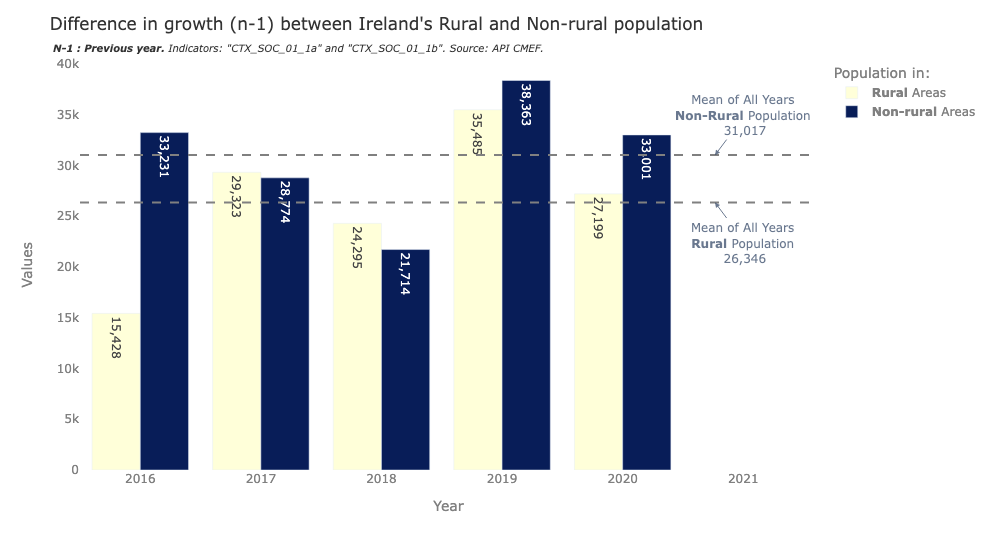

In [67]:
df = ind_pop[(ind_pop.year != 2015) & (ind_pop.memberStateName == 'Ireland')]
source = pd.melt(df, id_vars='year', value_vars=['rural_diff', 'non_rural_diff'])


title = "Difference in growth (n-1) between Ireland's Rural and Non-rural population" \
        f'<br><span style="font-size:10px"><i><b> N-1 : Previous year. </b></span></i>'\
        f'<span style="font-size:10px"><i>Indicators: "CTX_SOC_01_1a" and "CTX_SOC_01_1b". Source: API CMEF. </span></i>'

trace_colors = {
    'rural_diff' : '#ffffd9',
    'non_rural_diff':'#081d58'}
    
newnames = {'rural_diff' : '<b>Rural</b> Areas', 
            'non_rural_diff':'<b>Non-rural</b> Areas'}


fig = plot_bar_dif(source, 'year', 'value', 'variable', trace_colors, True)
    

fig.update_layout(xaxis_title_text = 'Year',
                yaxis_title_text = 'Values',
                legend_title_text= 'Population in:')

fig.add_hline(y= df['rural_diff'].mean(), 
              line_width=2, 
              line_dash="dash", 
              line_color="gray")

fig.add_hline(y= df['non_rural_diff'].mean(), 
              line_width=2, 
              line_dash="dash", 
              line_color="gray")


fig.add_annotation(x=2020.6, y=df['rural_diff'].mean(),
                   text= f"Mean of All Years <br><b>Rural</b> Population <br>{df['rural_diff'].mean():,.0f}",
                   showarrow=True,
                   arrowhead=2,
                   ax=30,
                   ay=40,
                   opacity=0.7,
                   xshift=20)

fig.add_annotation(x=2020.6 , y= df['non_rural_diff'].mean(),
                   text= f"Mean of All Years <br><b>Non-Rural</b> Population <br>{df['non_rural_diff'].mean():,.0f}",
                   showarrow=True,
                   arrowhead=2,
                   ax=30,
                   ay=-40,
                   opacity=0.7,
                   xshift=20)


fig.update_traces(textposition='inside')

fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))


fig.show()

#### Population Growth Rate

In [180]:
#Calculate the population growth rate.
#PGR = P(t) - P(t0)/(P(t0) * (t - t0))

#Calculate Doubling Time (DT) just use rule of 70 (trick from the field of economics) 

def calc_pgr(df, countries, value_cols, time_start, time_end):
    data = pd.DataFrame()
    i = 0 
    for country in countries:
        for c in value_cols:
            start = df[(df.memberStateName == country) & (df.year == time_start)].iloc[0][c]
            end = df[(df.memberStateName == country) & (df.year == time_end)].iloc[0][c]
            pgr = (((end - start)/start)*100)/(time_end-time_start)
            dt = 70 / pgr
            
            data.loc[i, 'memberStateName'] = country
            data.loc[i, 'values'] = c
            data.loc[i, f'pgr'] = pgr
            data.loc[i, f'dt'] = dt
            
            i += 1
            
    return data

In [181]:
ind_pop_r = calc_pgr(df = ind_pop,
             countries = ind_pop.memberStateName.unique(),
             value_cols = ['total', 'rural', 'non_rural'],
             time_start = 2015,
             time_end = 2020)

ind_pop_r.head(3)

memberStateName     values       pgr          dt
0         Austria      total  0.736496   95.044699
1         Austria      rural  0.362840  192.922719
2         Austria  non_rural  0.995051   70.348181

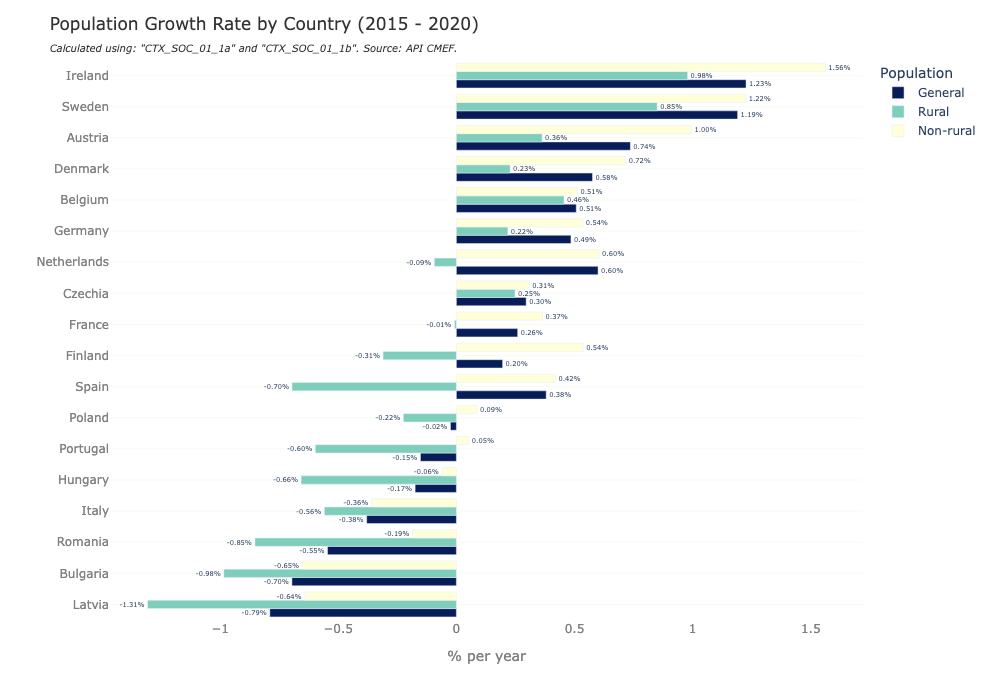

In [202]:
source = ind_pop_r
#mean_total = ind_pop_r['value_y'].mean()
#mean_rural = ind_pop_r['value_y'].mean()

title = f'Population Growth Rate by Country (2015 - 2020)' \
        f'<br><span style="font-size:10px"><i>Calculated using: "CTX_SOC_01_1a" and "CTX_SOC_01_1b". Source: API CMEF.</span></i>'

newnames = {'rural' : 'Rural', 
            'non_rural':'Non-rural',
           'total':'General'}

fig = px.bar(
    source,
    y = 'memberStateName',
    x = 'pgr',
    color = 'values',
    text = source['pgr'].map('{:,.2f}%'.format),
    orientation = "h",
    barmode='group',
    color_discrete_map={"total": "#081d58", "non_rural" : "#ffffd9", 'rural': '#7fcdbb'},
    )
'''
fig.add_vline(x= mean_rural, 
              line_width=2, 
              line_dash="dash", 
              line_color="gray")

fig.add_vline(x= mean_total, 
              line_width=2, 
              line_dash="dash", 
              line_color="gray")


fig.add_annotation(x= mean_rural, y='Ireland',
                   text= f"Mean of All Countries <br>Rural Population <br>{mean_rural:,.0f}",
                   showarrow=True,
                   arrowhead=2,
                   ax=-80,
                   opacity=0.7,
                   xshift=-5)

fig.add_annotation(x= mean_total, y='Bulgaria',
                   text= f"Mean of All Countries <br>General Population <br>{mean_total:,.0f}",
                   showarrow=True,
                   arrowhead=2,
                   ax=80,
                   opacity=0.7,
                   xshift=5)
'''

fig.update_layout(
    showlegend=True,
    title_text=title,
    title_font_color='#333333',
    width = 900,
    height=700,
    plot_bgcolor='white',
    #yaxis_visible=False,
    xaxis_title_font_color='grey',
    yaxis_title_font_color='grey',
    yaxis_color='grey',
    xaxis_color='grey',
    xaxis_title_text = '% per year',
    yaxis_title_text = '',
    yaxis_gridcolor = '#F7FCF0',
    #xaxis_showgrid=True, 
    coloraxis_showscale=False,
    legend_title_text= 'Population',)

fig.update_yaxes(categoryorder='total ascending', side="left")

fig.update_traces(textfont_size=8, textposition='outside')

fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

fig.show()

In [182]:
ind_pop_r[ind_pop_r.memberStateName == 'Ireland']

memberStateName     values       pgr         dt
27         Ireland      total  1.226318  57.081424
28         Ireland      rural  0.978692  71.524026
29         Ireland  non_rural  1.562024  44.813645

We can see that the population growth rate of Ireland is 1.2263% per year between 2015 and 2020, at this rate the Irish population would double in 57.0814 years. While the rural population grew at a rate of 0.9787% per year and would double in 71.5240 years the non-rural population grew at a rate of 1.5620% per year and would double in 44.8136 years.

In [ ]:
ind_pop[ind_pop['memberStateName']== 'Ireland']

In [ ]:
ind_pop['non_rural_diff_i'] = ind_pop['non_rural_diff'] / ind_pop['rural_diff']
ind_pop[ind_pop['memberStateName']== 'Ireland']

In [ ]:
ind_pop[ind_pop['memberStateName']== 'Finland']

In [ ]:
ind_pop[ind_pop['memberStateName']== 'Italy']

In [ ]:
#Creating labels for differents types 

for x in range(len(ind_pop)):
    if ind_pop.loc[x,'total_diff'] < 0:
        if ind_pop.loc[x,'rural_diff'] < 0:
            ind_pop.loc[x,'desc'] = 'General population loss'
        else:
            ind_pop.loc[x,'desc'] = 'Loss of non-rural population'
    else:
        if ind_pop.loc[x,'rural_diff'] < 0:
            ind_pop.loc[x,'desc'] = 'Loss of rural population'
        else:
            ind_pop.loc[x,'desc'] = 'General population gain'

ind_pop[ind_pop['memberStateName']== 'Ireland']

In [ ]:
ind_pop[ind_pop['desc']== 'Loss of non-rural population']

In [ ]:
source = ind_pop[ind_pop.year != 2015].groupby(['desc', 'year']).count().reset_index()


title = 'Types of Losses and Gains of the Population' \
        f'<br><span style="font-size:10px"><i>Count the number of countries that have lost or gained population per year.</span></i>'

trace_colors = {
    'General population loss' : '#ffffd9',
    'Loss of non-rural population': '#7fcdbb',
    'Loss of rural population': '#1d91c0',
    'General population gain':'#081d58'}
    

fig = px.bar(
    source,
    x = 'year',
    y = 'total',
    color = 'desc',
    text = source['total'],#.map('{:,.2f}'.format),
    orientation = "v",
    barmode='group',
    color_discrete_map = trace_colors
    #color_continuous_scale='YlGnBu'
    )


fig.update_layout(
    showlegend=True,
    title_text=title,
    title_font_color='#333333',
    legend_font_color='gray',
    legend_itemclick='toggleothers',
    legend_itemdoubleclick='toggle',
    width = 800,
    height=550,
    plot_bgcolor='white',
    xaxis_title_font_color='grey',
    xaxis_color='grey',
    yaxis_title_font_color='grey',
    yaxis_color='grey',
    xaxis_title_text = 'Year',
    yaxis_title_text = 'Amount of countries',
    legend_title_text= 'Description'
        )

fig.update_yaxes(categoryorder='total ascending')


fig.show()

In [ ]:
ind_pop[ind_pop.year != 2015].reset_index(drop=True)

In [ ]:
source = ind_pop[(ind_pop.year != 2015) & (ind_pop.memberStateName == 'Italy')]


title = "Difference in growth between Italy's Rural and Non-rural population per year" \
        f"<br><span style='font-size:10px'><i>Difference in growth compared to the previous year between Italy's Rural and Non-rural population. </span></i>"

trace_colors = {
    'rural_diff' : '#ffffd9',
    'non_rural_diff':'#081d58'}
    
newnames = {'rural_diff' : 'Rural Areas', 
            'non_rural_diff':'Non-rural Areas'}


fig = plot_bar_dif(source, 'year', ['rural_diff', 'non_rural_diff'], trace_colors, True)

fig.update_layout(xaxis_title_text = 'Year',
                  yaxis_title_text = 'Values',
                  legend_title_text= 'Population in:',
                  title_pad_t= 1000,
                 )

#fig.update_xaxes(categoryorder='total descending',side="top")

fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

In [ ]:
source = ind_pop[(ind_pop.year != 2015) & (ind_pop.memberStateName == 'Finland')]


title = "Difference in growth between Finland's Rural and Non-rural population per year" \
        f"<br><span style='font-size:10px'><i>Difference in growth compared to the previous year between Finland's Rural and Non-rural population. </span></i>"

trace_colors = {
    'rural_diff' : '#ffffd9',
    'non_rural_diff':'#081d58'}
    
newnames = {'rural_diff' : 'Rural Areas', 
            'non_rural_diff':'Non-rural Areas'}


fig = plot_bar_dif(source, 'year', ['rural_diff', 'non_rural_diff'], trace_colors, True)

fig.update_layout(xaxis_title_text = 'Year',
                  yaxis_title_text = 'Values',
                  legend_title_text= 'Population in:',
                  title_pad_t= 1000,
                 )

#fig.update_xaxes(categoryorder='total descending',side="top")

fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

In [ ]:
#Creating a DataFrame with difference between the previous year

source = ind_pop[(ind_pop.year != 2015)]# & (ind_pop.desc == 'General population loss')].reset_index(drop=True)


#plotting the differencies
lp = LinePlot('Difference (pp) between the Previous Year' \
               '<br><span style="font-size:10px"><i>Difference between the previous year over 2015 and 2020 by country.</span></i>')

trace_colors = {
    'Mean EU-19': '#ff4754',
    'Finland': '#081d58',
    'Romania': '#225ea8',
    'Austria': '#7fcdbb',
    'Ireland': '#ffffd9'
}

traces = list(source.memberStateName.unique())

x_names = list(source.year.unique())

plot_lines(
    lp, 
    data= source,
    traces= traces, 
    x_names= x_names, 
    agg_column='rural_diff', 
    group_column='year',
    trace_column='memberStateName', 
    trace_colors=trace_colors,
    hover_template='%{y:,.2f}pp'
)

xaxis_title='year'
yaxis_title='Difference (pp)'
lp.update_axis_title(xaxis_title, yaxis_title)
lp.show()

## Working-Age Population

Understanding how the rural population is occupying the country's workforce and how aged or youthful it is. In this way, we can understand whether there is a flight from the young population and thus have a perspective of the future.

In [ ]:
ind_age = ind[ind.code == 'CTX_SOC_02_1b'].reset_index(drop = True)
ind_age.sample(2)

# TESTE

In [ ]:
ind[(ind.memberStateName == 'Ireland') & (ind.indicator == 'C.02 Age structure') & (ind.year == 2020)]

In [ ]:
ind_ie = ind[ind.memberStateCode == 'IE']
source = ind_ie[ind_ie.code.isin(['CTX_SOC_01_2b','CTX_SOC_01_2a','CTX_SOC_01_2c'])]

type_regions = {
    'rural regions': 'Rural', 
    'urban regions': 'Urban',
    'intermediate regions': 'Intermediate'}

source = source.replace({'parameter':type_regions})

In [ ]:
trace_colors = {
    'Rural': '#004b66', 
    'Urban': '#ff4754',
    'Intermediate': '#2dbaaf'}

title = 'Distribution of Population by Type of Region' \
        '<br><span style="font-size:10px"><i>Understanding distribution of population by type of region over the years.</span></i>'

fig = px.bar(
    source,
    y = 'year',
    x = 'value',
    color = 'parameter',
    text = 'value',
    orientation = "h",
    barmode='group',
    color_discrete_map = trace_colors
    )


fig.update_layout(
    showlegend=True,
    title_text=title,
    title_font_color='#333333',
    legend_font_color='gray',
    legend_itemclick='toggleothers',
    legend_itemdoubleclick='toggle',
    width = 800,
    height=550,
    plot_bgcolor='white',
    xaxis_title_font_color='grey',
    xaxis_color='grey',
    yaxis_title_font_color='grey',
    yaxis_color='grey',
    
    xaxis_title_text = 'Value (%)',
    yaxis_title_text = 'Year',
    legend_title_text= 'Type of Region'
        )



fig.show()

Ploting the difference in percentage points 

In [ ]:
#Creating a df of the differencies between the previous year.
source_1 = pd.pivot(source, index = 'year', columns ='parameter', values='value').reset_index().reset_index()
source_1['Rural'] = source_1['Rural'].diff()
source_1['Intermediate'] = source_1['Intermediate'].diff()
source_1['Urban'] = source_1['Urban'].diff()
source_1 =pd.melt(source_1, id_vars=['year'], value_vars=['Rural', 'Intermediate', 'Urban'])
source_1 = source_1.fillna(0)

#checking the means of the differencies for regions
regions = ['Rural','Intermediate' ,'Urban']
for i in regions:
    m = source_1[source_1.parameter == i].value.mean()
    print(f"{i}'s mean of diff: {m:.4} pp")

#plotting the differencies
lp = LinePlot('Variation Between Region Types' \
               '<br><span style="font-size:10px"><i>Understanding Variation Between Region Types over the years.</span></i>')

traces = list(source_1.parameter.unique())

x_names = list(source_1.year.unique())

plot_lines(
    lp, 
    data=source_1,
    traces=traces, 
    x_names=x_names, 
    agg_column='value', 
    group_column='year',
    trace_column='parameter', 
    trace_colors=trace_colors,
    hover_template='%{y:,.2f}pp'
)

xaxis_title='year'
yaxis_title='Difference (pp) between the previous year'
lp.update_axis_title(xaxis_title, yaxis_title)
lp.show()

In [ ]:
print("Variance")
for tr in trace_colors:
    print(f"{tr}: {statistics.variance(source_1[source_1.parameter == tr]['value']):.6f}")

In [ ]:
print("Standard Deviation (SD)")
for tr in trace_colors:
    print(f"{tr}: {statistics.stdev(source_1[source_1.parameter == tr]['value']):.6f}")

In [ ]:
def get_category_segment_df(
    dataframe, 
    seg_col, 
    cat_col, 
    normalize=False,
    drop_thresh=4,
    ):
    """
    returns the counts of segments within each category.
    normalizing the data will return a percentage instead.
    segments with counts smaller than drop_thresh will be dropped. 
    """
    
    cat_seg_df = dataframe.groupby([seg_col, cat_col]).size()
    cat_seg_df = cat_seg_df[cat_seg_df > drop_thresh]
    cat_seg_norm_df = (cat_seg_df.unstack()/ cat_seg_df.unstack().sum()).stack()
    
    if normalize:
        return cat_seg_norm_df * 100
    else:
        return cat_seg_df
    

def plot_category_segment_hist(
    dataframe, 
    seg_col, 
    cat_col, 
    seg_list= None,
    cat_list = None,
    replace_dict=None, 
    normalize=False,
    marker_color=None,
    orientation='v',
    area=False,
    drop_thresh=4,
    **kwargs,
    ):
    """
    plots a bar or area chart showing counts (or percentages) of segments within each category.
    this uses the get_category_segment_df() function to construct the dataftame.
    """
        
    if marker_color is None:
        marker_color = px.colors.sequential.YlOrRd
        
    df = dataframe.dropna(axis=0, subset=[seg_col]).copy()
    
    if replace_dict is not None:
        df = df.replace(replace_dict)
        
    cat_seg_df = get_category_segment_df(df, seg_col, cat_col, normalize=normalize, drop_thresh=drop_thresh)
    
    if seg_list is None:
        seg_list = df[seg_col].dropna().unique()
    
    groups = [cat_seg_df[seg] for seg in seg_list]
    
    if cat_list is not None:
        groups = [group.reindex(cat_list) for group in groups]
        

    def axis_flipper(group):
        
        if orientation == 'v':
            return group.index, group
        
        elif orientation == 'h':
            return group, group.index
    
    if area:
        plotter = go.Scatter
        stack_arg = dict(stackgroup='one')
    else:
        plotter = go.Bar
        stack_arg = dict()
    
    traces = [
        plotter(
            x = axis_flipper(group)[0], 
            y = axis_flipper(group)[1],
            name = seg,
            marker_color = marker_color[i],
            orientation = orientation,
            hovertext = seg,
            **stack_arg,
        )
        for i, (seg, group) in enumerate(zip(seg_list, groups))]

    fig = go.Figure(traces)

    fig.update_layout(barmode = 'stack',
                      font_family = "Tahoma",
                      font_size = 14,
                      paper_bgcolor = paper_bgcolor,
                      plot_bgcolor = plot_bgcolor,
                      title_font_size = 25,
                      width=1000,
                      height=650,
                      xaxis_fixedrange=True, 
                      yaxis_fixedrange=True,
                     **kwargs,)
    return fig

In [ ]:
def plot_category_segment_polar(
    values, 
    cat_col, 
    seg_col, 
    normalize=False,
    cat_list=None, 
    seg_list=None, 
    theta_labels=None,
    marker_color=px.colors.sequential.Greens[1:],
    drop_thresh=5,
    title=None,
    rotation=0,
    **kwargs
    ):
    """
    plots a radial bar chart showing counts (or percentages) of segments within each category.
    this uses the get_category_segment_df() function to construct the dataftame and windrose_plot() to make the plot.
    """
    
    if seg_list is None:
        seg_list = values[seg_col].unique()
        
    cat_seg_df = get_category_segment_df(
        values, cat_col=cat_col, seg_col=seg_col, 
        normalize=normalize,     drop_thresh=drop_thresh).reset_index()
    
    
    cat_seg_df["sorter"] = cat_seg_df[seg_col].map( {v: k for k,v in enumerate(seg_list[::-1])})
    cat_seg_df = cat_seg_df.sort_values(["sorter", 0], ascending=[False, True])

    add_percent_sign = "(%)" if normalize else ""
    fig = windrose_plot(cat_seg_df, cat_col, seg_col, 
                        cat_list = cat_list, 
                        seg_list = seg_list, 
                        theta_labels = theta_labels,
                        marker_color = marker_color,
                        title = title,
                        hovertemplate = "%{r:.1f} " + add_percent_sign + " of this category<br>are in the %{fullData.name} bracket.",
                        **kwargs) 
    fig.update_polars( angularaxis=dict(direction="clockwise", rotation=90 + rotation))
    
    return fig